# FIFA23 analysis of players attributes & potential for growth

This workbook is to explore the popular EA FIFA 23 video game data, specifically looking at players attributes & ratings and trying to find out what may influence players' growth potential.

Workbook contains:
- [Business and Data Understanding](#business-data-understanding)
- [Prepare Data](#prepare-data)
- [Data Modeling](#data-modeling)
- [Evaluate the Results / Summary](#summary)

## Business and Data Understanding<a id='business-data-understanding'></a>

FIFA 23 players data can be downloaded from Kaggle: https://www.kaggle.com/datasets/cashncarry/fifa-23-complete-player-dataset?select=players_fifa23.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
df = pd.read_csv(r'datasets\players_fifa23.csv', header=0)
df.head()

,ID,Name,FullName,Age,Height,Weight,PhotoUrl,Nationality,Overall,Potential,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,158023,L. Messi,Lionel Messi,35,169,67,https://cdn.sofifa.net/players/158/023/23_60.png,Argentina,91,91,...,91,88,91,67,66,67,62,53,62,22
1,165153,K. Benzema,Karim Benzema,34,185,81,https://cdn.sofifa.net/players/165/153/23_60.png,France,91,91,...,89,84,89,67,67,67,63,58,63,21
2,188545,R. Lewandowski,Robert Lewandowski,33,185,81,https://cdn.sofifa.net/players/188/545/23_60.png,Poland,91,91,...,86,83,86,67,69,67,64,63,64,22
3,192985,K. De Bruyne,Kevin De Bruyne,31,181,70,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,91,91,...,91,91,91,82,82,82,78,72,78,24
4,231747,K. Mbappé,Kylian Mbappé,23,182,73,https://cdn.sofifa.net/players/231/747/23_60.png,France,91,95,...,92,84,92,70,66,70,66,57,66,21


In [4]:
df.shape

(18539, 90)

In [5]:
#check if there are any columns with empty rows, we might want to exclude them in the later stage

df.columns[df.isnull().mean() > 0]

Index(['ClubPosition', 'ContractUntil', 'ClubNumber', 'NationalPosition',
       'NationalNumber'],
      dtype='object')

In [6]:
pd.set_option('display.max_rows', 100)
#df.dtypes

**How does Overall and Potential rating look in general?**

Let's first look at Overall and Potential ratings and see how their distribution look like.

In [7]:
def plot_histogram(df, var):
    ''' 
    this function is to see distribution of a single variable and plotting it as histogram
    INPUT: df - dataframe, var - variable name    
    '''
    sns.histplot(df[var], alpha = 0.3, kde = True)

    return plt.show()

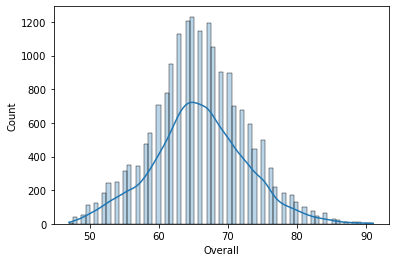

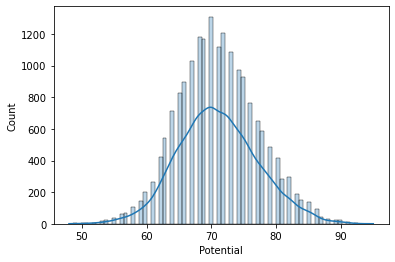

In [8]:
plot_histogram(df, 'Overall')
plot_histogram(df, 'Potential')

<AxesSubplot:xlabel='Potential', ylabel='Overall'>

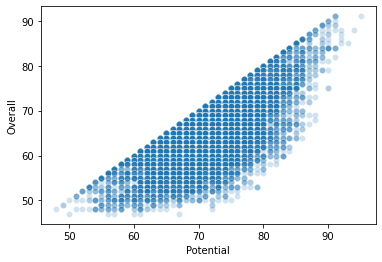

In [9]:
sns.scatterplot(data = df, x = 'Potential', y = 'Overall', alpha = 0.2)

In [10]:
df['Overall'].corr(df['Potential'])

0.6606297404538514

**Where is the potential for growth?**

Overall and Potential have similar distribution and both ratings seem to be positively correlated. Apart from looking at them separately it might be interesting to investigate gaps between Overall and Potential.

Growth is a difference between Overall and Potential that suggests player's remaining potential for growth. Let's take a closer look into it.

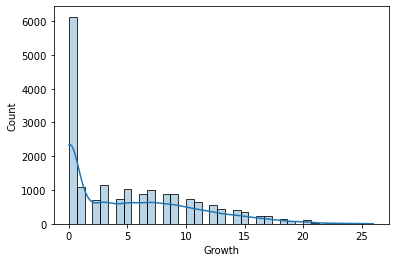

In [11]:
plot_histogram(df, 'Growth')

In [12]:
df[df['Growth'] < 1].shape[0]/df.shape[0]

0.3307082366902206

**How Growth is related to other attributes?**

Around 30 % of players in FIFA23 have Potential very close or equal to their Overall rating, but looking at the distribution of Growth we can notice that for some players remaining potential for growth is still quite high. Let's try to find out what may drive those differences.

We can check correlation between selected numerical attributes and Growth.

In [13]:
#limit df to only general attributes
#Growth is derived from Overall and Potential so those will not be included

df_subset = df[['Growth', 'Age', 'Height', 'Weight', 'ValueEUR', 'IntReputation', 'Crossing', 'Finishing',
                'Volleys', 'Dribbling', 'Acceleration', 'SprintSpeed','Reactions', 'Balance',
                'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Composure']]

In [14]:
def correlation_matrix(df):
    '''
    This function calculates correlation coeficients between variables and plots them as correlation matrix
    '''
    corr = df.corr()
    mask = np.triu(corr)

    fig = plt.figure(figsize = (14, 10))
    ax = fig.gca()

    plot = sns.heatmap(corr, annot = True, fmt = '.2f', ax = ax, 
                cmap = sns.diverging_palette(220, 20, n=200),
                mask = mask)
    
    return plot

<AxesSubplot:>

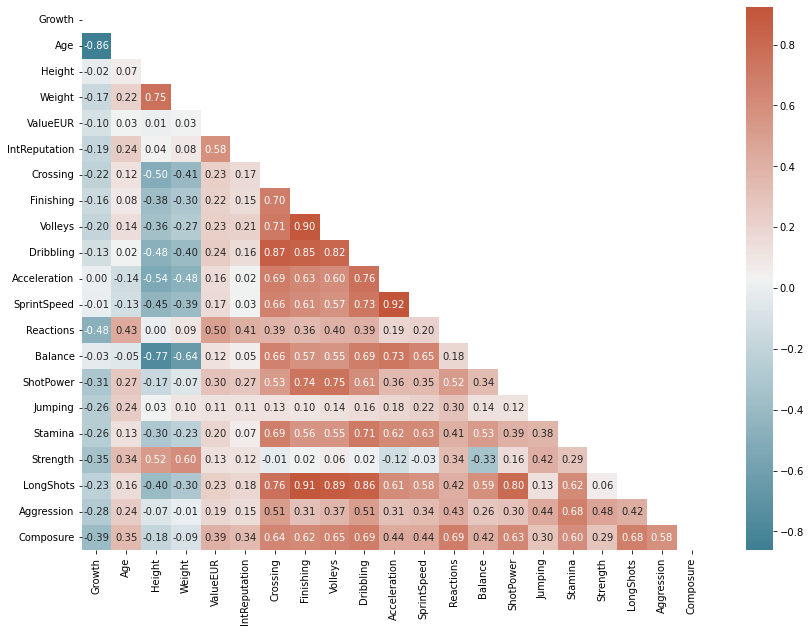

In [15]:
correlation_matrix(df_subset)

## Prepare Data <a id='prepare-data'></a>

**How Growth looks in selected categories?**

We can take a closer look at Growth of players grouped accoridng to their best positions, but first let's decipher the abbreviations used in FIFA dataset:
* GK - Goalkeeper
* CB - Centre-Back
* RB, LB - Right-Back, Left-Back
* RWB, LWB - Right Wing-Back, Left Wing-Back
* CDM - Defensive Midfielder
* CM - Centre Midfielder
* CAM - Central Attacking Midfielder
* RM, LM - Right Midfielder, Left Midfielder
* RW, LW - Right Winger, Left Winger
* CF - Centre Forward
* ST - Striker

To make the analysis easier let's group the positions into 3 categories: Attack, Midfield, Defense

In [16]:
# Attack: ST, CF, LW, RW
# Midfield: CM, CAM, LM, RM, CDM
# Defense: GK, CB, AB, LB, RWB, LWB 

attack = df['BestPosition'].isin(['ST', 'CF', 'LW', 'RW'])
mid = df['BestPosition'].isin(['CM', 'CAM', 'LM', 'RM', 'CDM'])
defense = df['BestPosition'].isin(['GK', 'CB', 'AB', 'LB', 'RB', 'RWB', 'LWB'])

groups = ['Attack', 'Midfield', 'Defense']

positions = [attack, mid, defense]

df['BestPositionGroup'] = np.select(positions, groups)

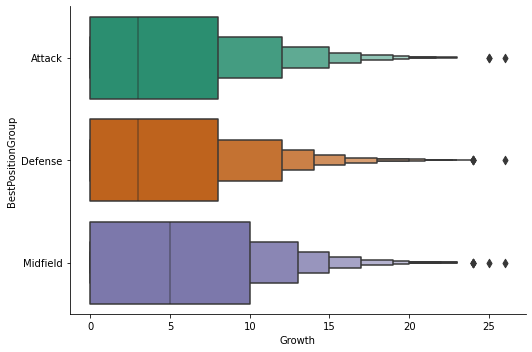

In [17]:
# color palette as dictionary
palette = {'Midfield':"Dark2:green",
           'Attack':"tab:orange", 
           "Defense":"tab:purple"}

sns.catplot(
    data = df, x = "Growth", y = "BestPositionGroup", #hue="PreferredFoot",
    kind = "boxen",
    aspect = 1.5,
    palette = "Dark2",
    order=["Attack", "Defense", "Midfield"])

In [18]:
df.groupby(by = ['BestPositionGroup'])['Growth'].mean()

BestPositionGroup
Attack      4.675564
Defense     4.875690
Midfield    5.723859
Name: Growth, dtype: float64

**Can we model Growth using independent variables?**

We can try to create a model with Growth as a target variable to see how well changes in Growth can be explained with other variables we have at hand.

In [19]:
#we will use only general attributes
df_to_model = df[['Growth', 'Age', 'Height', 'Weight', 'ValueEUR', 'IntReputation', 'Crossing', 'Finishing',
                'Volleys', 'Dribbling', 'Acceleration', 'SprintSpeed','Reactions', 'Balance',
                'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Composure']]

In [20]:
df_to_model.head()

,Growth,Age,Height,Weight,ValueEUR,IntReputation,Crossing,Finishing,Volleys,Dribbling,...,SprintSpeed,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Composure
0,0,35,169,67,54000000,5,84,90,88,95,...,76,92,95,86,68,70,68,91,44,96
1,0,34,185,81,64000000,4,75,92,88,87,...,80,92,72,87,79,82,82,80,63,90
2,0,33,185,81,84000000,5,71,94,89,85,...,75,93,82,91,85,76,87,84,81,88
3,0,31,181,70,107500000,4,94,85,83,88,...,73,91,78,92,63,88,74,91,75,89
4,4,23,182,73,190500000,4,78,93,83,93,...,97,93,81,88,77,87,76,82,64,88


We will also preapre another subset with categorical variables

In [21]:
#adding two categorical variables: BestPositionGroup and PreferredFoot

df_model_cat = pd.concat([df_to_model, df[['PreferredFoot', 'BestPositionGroup']]], axis = 1)

In [22]:
df_model_cat = pd.get_dummies(df_model_cat, prefix_sep = '_', columns = ['PreferredFoot', 'BestPositionGroup'])

## Data Modeling<a id='data-modeling'></a>

OLS with continuous variables

In [23]:
x = df_to_model.drop(['Growth'], axis = 1)
y = df_to_model['Growth']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     3270.
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:08:54   Log-Likelihood:                -43476.
No. Observations:               18539   AIC:                         8.699e+04
Df Residuals:                   18518   BIC:                         8.716e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            32.7333      0.958     34.182

OLS with continuous and two categorical variables

In [24]:
x_cat = df_model_cat.drop(['Growth'], axis = 1)

x_cat = sm.add_constant(x_cat)

model_with_cat = sm.OLS(y, x_cat).fit()

print(model_with_cat.summary())

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2846.
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:08:56   Log-Likelihood:                -43467.
No. Observations:               18539   AIC:                         8.698e+04
Df Residuals:                   18515   BIC:                         8.717e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Evaluate the results/ Summary<a id='summary'></a>

In [25]:
def ols_coefficients(model):
    '''
    Returns coefficients and errors from OLS model as dataframe.
    Input: model - fitted model
    '''
    coefs_df = pd.DataFrame()
    coefs_df['coefs'] = model.params
    error_interval = model.params - model.conf_int()[0]
    coefs_df['error'] = error_interval.values

    #drop constant
    coefs_df = coefs_df.drop(['const'], axis = 0).reset_index()

    return coefs_df

In [26]:
coefs_df = ols_coefficients(model)
coefs_df

,index,coefs,error
0,Age,-9.428249e-01,1.026176e-02
1,Height,1.534895e-02,1.035875e-02
2,Weight,-1.372671e-02,8.992190e-03
3,ValueEUR,-3.503094e-08,6.616294e-09
4,IntReputation,1.174242e+00,1.322663e-01
5,Crossing,-1.911557e-02,4.566739e-03
6,Finishing,2.673093e-03,5.798716e-03
7,Volleys,5.255504e-03,5.362963e-03
8,Dribbling,1.794116e-02,6.478082e-03
9,Acceleration,-1.140227e-02,7.226095e-03


In [27]:
#coefs sort from highest to lowest based on their absolute value

coefs_df['abs_coefs'] = np.abs(coefs_df['coefs']).round(4)
coefs_df.sort_values('abs_coefs', ascending = False)

,index,coefs,error,abs_coefs
4,IntReputation,1.174242e+00,1.322663e-01,1.1742
0,Age,-9.428249e-01,1.026176e-02,0.9428
11,Reactions,-5.700816e-02,6.705930e-03,0.0570
15,Stamina,-3.989691e-02,4.244124e-03,0.0399
5,Crossing,-1.911557e-02,4.566739e-03,0.0191
8,Dribbling,1.794116e-02,6.478082e-03,0.0179
18,Aggression,1.734250e-02,3.607070e-03,0.0173
16,Strength,-1.705380e-02,5.224820e-03,0.0171
1,Height,1.534895e-02,1.035875e-02,0.0153
2,Weight,-1.372671e-02,8.992190e-03,0.0137


In [28]:
def plot_coefficients(model):
    '''
    Returns plot of regression coefficients.
    Input: model - fitted model
    '''
    coefs_df = ols_coefficients(model)

    fig, ax = plt.subplots(figsize=(10, 4))

    coefs_df.plot(x = 'index', y = 'coefs', kind = 'bar', color = 'none',
             ax = ax, yerr = 'error', ecolor = 'black', legend = False)

    ax.scatter(x = np.arange(coefs_df.shape[0]), 
           marker = 'o', s = 50, 
           y = coefs_df['coefs'], color='black')

    ax.set_xlabel('Attribute')
    ax.set_ylabel('Coefficient')

    ax.axhline(y = 0, linestyle='--', color = 'red', linewidth = .5)

    return plt.show()

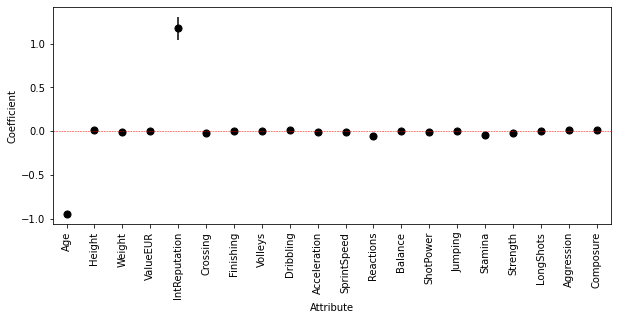

In [29]:
plot_coefficients(model)

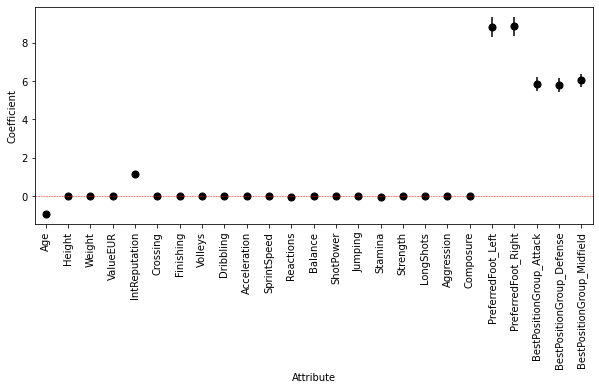

In [30]:
plot_coefficients(model_with_cat)

Almost 80% of changes in Growth can be explained by the model with continuous variables! Most important factors are Age and IntReputation. Adding two categorical variables does not change how well data fit the model (R-squared), but the results suggest that Midfield positions have slightly higher potential for Growth. Let's try to bring the results of our analysis alltogether in one chart!

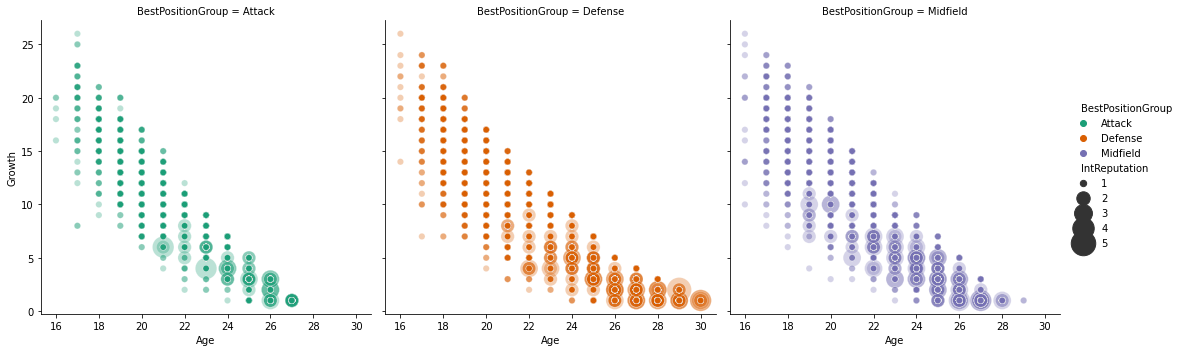

In [31]:
#limit dataset to players with Potential different from Overall

df_growth = df[df['Growth'] != 0]

sns.relplot(x = "Age", y="Growth", hue = "BestPositionGroup", size = "IntReputation",
            sizes=(40, 600), alpha = 0.3, palette = "Dark2", col = "BestPositionGroup",
            height = 5, data = df_growth)

In [32]:
df_growth.groupby(by = ['BestPositionGroup'])['Age'].mean()

BestPositionGroup
Attack      22.332438
Defense     23.041487
Midfield    22.213339
Name: Age, dtype: float64